Import packages

In [19]:
import re
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

Set global variables

In [20]:
OUTPUT_PATH = '../data/postprocessing/231212_compare_electrolyzers/1x_gas_wi_storage_'

Read output data

In [21]:
output_df = pd.read_csv(OUTPUT_PATH + 'output_time_series.csv', index_col=0)
print(output_df.columns)

Index(['gas_price', 'power_price', 'chp.bin', 'chp.gas', 'chp.power',
       'chp.heat', 'electrical_grid.overall_power',
       'electrical_grid.supply_power', 'electrical_grid.feedin_power',
       'battery_storage.power_balance', 'battery_storage.charging_power',
       'battery_storage.discharging_power', 'battery_storage.energy_content',
       'battery_storage.discharge_bin', 'battery_storage.charge_bin',
       'battery_storage.switch_bin', 'pv.power', 'electrolyzer.bin',
       'electrolyzer.hydrogen', 'electrolyzer.power', 'electrolyzer.water',
       'electrolyzer.heat', 'hydrogen_grid.overall_hydrogen',
       'hydrogen_grid.supply_hydrogen', 'hydrogen_grid.feedin_hydrogen',
       'hydrogen_storage.hydrogen_balance',
       'hydrogen_storage.charging_hydrogen',
       'hydrogen_storage.discharging_hydrogen',
       'hydrogen_storage.hydrogen_content', 'hydrogen_storage.charge_bin',
       'hydrogen_storage.discharge_bin', 'arc1_expanded.power',
       'arc2_expanded.power',

Prepare class for Assets

In [22]:
class Assets:
    """Class for evaluating asset output data."""

    def __init__(self, input_data: pd.DataFrame) -> None:
        self.ids = []
        self.input_data = input_data
        self.asset_data = {}
        self.postprocess_data = {}
        self.objective_value = None

        self.get_asset_ids()
        self.get_asset_data()
        self.calc_postprocess_data()
        self.get_objective_value_from_log()


    def get_asset_ids(self):
        """Get all unique asset names from the input data."""
        ids_set = set()

        for column_name in self.input_data.columns:
            if not '.' in column_name:
                continue
            key = re.sub('\..*$', '', column_name)      # Replace every character after a '.'.
            key = key.replace('_expanded', '')          # Replace additional characters.
            ids_set.add(key)                            # Remove duplicate keys.
        
        for id in ids_set:
            self.ids.append(id)
        
        self.ids.sort()

        if not self.ids:
            raise ValueError("""Found no asset ids in input data.""")


    def get_asset_data(self):
        """Get the specific asset data from the input data."""

        for id in self.ids:
            asset_df = pd.DataFrame()

            for column_name in self.input_data.columns:
                if id in column_name:
                    key_name = re.sub('^.*\.', '', column_name)
                    asset_df[key_name] = self.input_data[column_name]
            
            self.asset_data[id] = asset_df


    def calc_postprocess_data(self):
        """Calculates the sum of all columns in the asset data."""

        for key in self.asset_data:
            asset_dict = {}
            for column in self.asset_data[key].columns:
                column_sum = self.asset_data[key][column].sum()
                asset_dict[column] = column_sum
                self.postprocess_data[key] = asset_dict
    
    
    def get_objective_value_from_log(self):
        """Gets the objective value from the solver log file."""

        with open(OUTPUT_PATH + 'solver.log', 'r') as log_file:
            for line in log_file:
                if 'Best objective' in line:
                    line = line.replace('Best objective ', '')
                    line = re.sub(',.*$', '', line)
                    self.objective_value = round(float(line), 1)
                    

    def check_objective_value(self):
        """Calculates the objective value from the output data and checks if it is identical 
        to the solver results."""

        result = sum(
            self.asset_data['chp']['gas'] * self.input_data['gas_price'] +
            self.asset_data['electrical_grid']['overall_power'] * self.input_data['power_price'] +
            self.asset_data['hydrogen_grid']['overall_hydrogen'] * self.input_data['gas_price'] * 1.0
            )
        result = round(result, 1)
        
        if result == self.objective_value:
            print('\nObjective value and calculated value are the same.')
            print(f'{self.objective_value} == {result}')
        else:
            print('\nObjective value and calculated value are not identical!')
            print(f'{self.objective_value} =/= {result}')


Calculate overview data for assets

In [23]:
assets = Assets(output_df)

df = pd.DataFrame(assets.postprocess_data)
print(df)

assets.check_objective_value()

                             arc1        arc2         arc3         arc4     arc5          arc6           arc8  battery_storage           chp  electrical_grid  electrolyzer  hydrogen_grid  hydrogen_storage          pv
power                 720939.9461  1198.73992  348348.7776  348348.7776  54763.7           NaN            NaN              NaN  7.209399e+05              NaN  5.476370e+04            NaN               NaN  1198.73992
hydrogen                      NaN         NaN          NaN          NaN      NaN  28040.378184  467130.059557              NaN           NaN              NaN  2.804038e+04            NaN               NaN         NaN
power_balance                 NaN         NaN          NaN          NaN      NaN           NaN            NaN     3.069545e-12           NaN              NaN           NaN            NaN               NaN         NaN
charging_power                NaN         NaN          NaN          NaN      NaN           NaN            NaN     3.483488e+05      

Create Plots

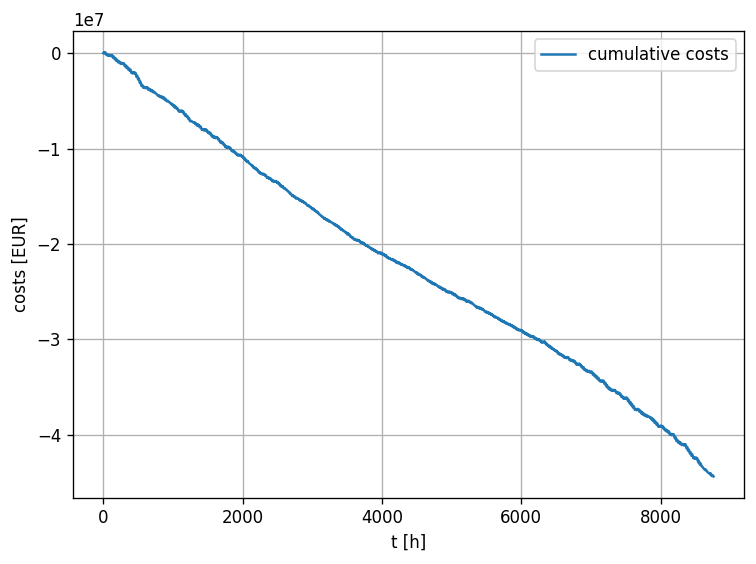

In [24]:
costs = (
    assets.asset_data['chp']['gas'] * assets.input_data['gas_price'] +
    assets.asset_data['electrical_grid']['overall_power'] * assets.input_data['power_price'] -
    assets.asset_data['electrolyzer']['hydrogen'] * assets.input_data['gas_price'] * 2.5
)

plt.figure(dpi=120)
costs.cumsum().plot(label='cumulative costs')
plt.xlabel('t [h]')
plt.ylabel('costs [EUR]')
plt.grid()
plt.legend()
plt.tight_layout()